In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fractions import Fraction
from matplotlib.colors import ListedColormap

import numba as nb
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display

import itertools


In [2]:
url='https://www.janestreet.com/puzzles/minesweeping-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[10:19]))))

### Minesweeping

The game
minesweeper
begins with a grid of un-revealed squares. Some squares contain mines beneath
them, and the rest do not. If a square does not contain a mine, then that square
will contain a number equal to the number of mines that square borders, even
diagonally. Once the board is fully-revealed, every square will contain either a
mine or a number. See Figure 1 for an example of a
fully-revealed 3×3 minesweeper board, and Figure 2 for an example of a
partially-revealed 3×4 minesweeper board.
This month’s puzzle: Consider a partially-revealed minesweeper board. For a
given unrevealed square S, let P(S) be the probability that S contains a mine,
assuming that all possible solutions for the partially-revealed board are
equally likely. Design your own partially-revealed
4x4
minesweeper board, trying
to maximize the value of P(S) for the square of your choice, while keeping P(S)
less than 1
.
For your submission, please submit your P and also your minesweeper grid, using
dashes and numbers for each row, as in the example submission under Figure 2.

<img src="https://www.janestreet.com/puzzles/Oct14_Examples2.png" width=600>

In [3]:
# put together some nice code to calculate the probability and visualise and then try manually
# Calulating all permutations and finding the valid ones wasn't too slow for this.
# Brute force would be very slow though (there are a LOT of symmetries and constraints so may be a way to try)

@nb.njit  
def neighbours(grid, i, j):
    (rows,cols) = grid.shape
    l=0
    for x in [-1,0,1]:
        for y in [-1,0,1]:
            if (x,y) !=(0,0) and i+x >= 0 and i+x < rows and j+y >= 0 and j+y < cols:
                l += grid[i+x,j+y]
    return l
    
@nb.njit   
def fits_grid(mines,grid):
    x,y =mines.shape
    for i in range(x):
        for j in range(y):
            if grid[i,j] != -1:
                if neighbours(mines,i,j) != grid[i,j]:
                    return False
                if mines[i,j] == 1:
                    return False
            
    return True 

In [4]:
def find_probs(test):
    a,b = test.shape
    possibilities = [np.array(i,dtype=int).reshape(a,b) for i in itertools.product(range(2), repeat=a*b)]
    out = [i for i in possibilities if fits_grid(i,test) ]
    numerator = np.sum(out,axis=0)
    denominator = len(out)
    return np.array([[Fraction(numerator[i,j],denominator) for j in range(numerator.shape[1])] 
                     for i in range(numerator.shape[0])])

def solver(grids):
    n = len(grids)
    count = 0
    fig,ax = plt.subplots(1,n,figsize=(3.5*n,3.5))
    for grid in grids:
        soln= find_probs(grid)
        x = np.array((soln).astype('str'))
        m = np.zeros((x.shape[0],x.shape[1]))
        m[grid==-1] = 1
        m[np.array(soln) == np.max(soln)] = 2
        x[grid != -1]= grid[grid != -1]
        ax[count]= sns.heatmap(m,annot=x,cbar=False,cmap=ListedColormap(["grey","w","yellow"]),
                               fmt="",linewidths=1,linecolor="k",annot_kws={"fontsize":14},ax=ax[count])
        ax[count].set_title("The solution is: {} ({:.4f})\n".format(np.max(soln),np.max(soln).numerator/np.max(soln).denominator,size=26))
        ax[count].axis("off")
        count +=1
    plt.tight_layout()
    plt.show()
    return np.max(soln)

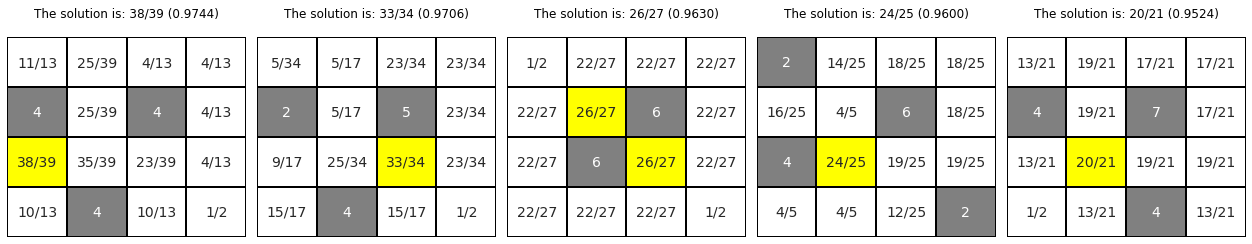

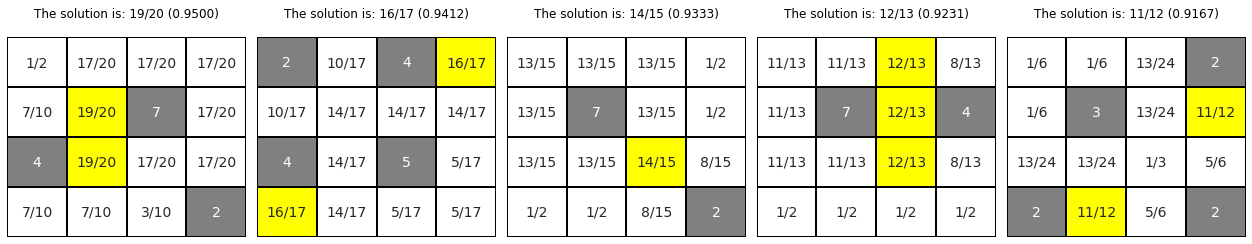


Took 3.6003 secs


In [5]:
# the trick is to have neighbours in he most possible cells without forcing any to be 1
# the 6-6 solution is easy to find (7-7 would force 1s) but doesn't cover 2 of the corner cells
# putting 2s in corners doesn't get very far so 4s on edges looks like a good strategy
# A few different versions below

test =np.array([[-1,-1,-1,-1],
                [ 4,-1, 4,-1],
                [-1,-1,-1,-1],
                [-1, 4,-1,-1]])

test1 =np.array([[-1,-1,-1,-1],
                [ 2,-1, 5,-1],
                [-1,-1,-1,-1],
                [-1, 4,-1,-1]])

test2 =np.array([[-1,-1,-1,-1],
                 [-1,-1, 6,-1],
                 [-1, 6,-1,-1],
                 [-1,-1,-1,-1]])

test3 =np.array([[2,-1,-1,-1],
                 [-1,-1, 6,-1],
                 [ 4,-1,-1,-1],
                 [-1,-1,-1, 2]])

test4 =np.array([[-1,-1,-1,-1],
                 [ 4,-1, 7,-1],
                 [-1,-1,-1,-1],
                 [-1,-1, 4,-1]])

test5 =np.array([[-1,-1,-1,-1],
                 [-1,-1, 7,-1],
                 [ 4,-1,-1,-1],
                 [-1,-1,-1, 2]])

test6 =np.array([[ 2,-1, 4,-1],
                 [-1,-1,-1,-1],
                 [ 4,-1, 5,-1],
                 [-1,-1,-1,-1]])

test7=np.array([[-1,-1,-1,-1],
                [-1, 7,-1,-1],
                [-1,-1,-1,-1],
                [-1,-1,-1, 2]])

test8=np.array([[-1,-1,-1,-1],
                [-1, 7,-1, 4],
                [-1,-1,-1,-1],
                [-1,-1,-1,-1]])

test9=np.array([[-1,-1,-1, 2],
                [-1, 3,-1,-1],
                [-1,-1,-1,-1],
                [ 2,-1,-1, 2]])


start=time.time()
soln =solver([test,test1,test2,test3,test4])
soln =solver([test5,test6,test7,test8,test9])
print("\nTook {:,.4f} secs".format(time.time()-start))

In [6]:
url='https://www.janestreet.com/puzzles/minesweeping-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("".join(y[10:1]))))

### October 2014 : Solution



<img src="https://www.janestreet.com/puzzles/Oct14_solution.png" width=300>